# 3.0 - Evaluation

In [1]:
import sys, os
from pathlib import Path
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".root"])

# append to path
sys.path.append(str(root))

In [11]:
import numpy as np
import xarray as xr
import pandas as pd

import hvplot.xarray
from xmovie import Movie

import matplotlib.pyplot as plt

# packages 
from src.obs import get_streaming_lines
from src.stats import rmse_coords, shortest_resolved_scale, compute_psd
from src.utils import check_coords, get_all_coords
from src.utils import reformat_time

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [3]:
ds = xr.open_dataset(root.joinpath("data/qg_sim.nc")).compute()
ds

<xarray.Dataset>
Dimensions:  (time: 125, Nx: 128, Ny: 128)
Coordinates:
  * Nx       (Nx) float64 -3.123 -3.074 -3.025 -2.976 ... 3.013 3.062 3.111
  * Ny       (Ny) float64 -3.123 -3.074 -3.025 -2.976 ... 3.013 3.062 3.111
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 117 118 119 120 121 122 123 124
Data variables:
    p        (time, Nx, Ny) float64 -0.492 -0.5498 -0.5995 ... -0.5521 -0.5281
    q        (time, Nx, Ny) float64 9.088 9.583 9.959 10.2 ... 3.312 2.035 1.55
    u        (time, Nx, Ny) float64 1.084 1.103 1.115 ... 0.8069 0.8096 0.8076
    v        (time, Nx, Ny) float64 -1.257 -1.096 -0.9257 ... 0.4581 0.5179
    obs_p    (time, Nx, Ny) float64 nan nan nan nan nan ... nan nan nan nan nan
    obs_q    (time, Nx, Ny) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    B:        0.0
    dt:       0.0004
    forcing:  wind_stress
    iters:    10000
    mu:       0.020053522829578813
    nu:       0.00016412040576263483
    nv:       1
    scale:    4
    sgs:      constant
    steps:    1000
    t0:       0.0

### Sanity Check

So in the case, to demonstrate how the code works, we'll just use the same data but add some random Gaussian distributed noise.

In [4]:
rng = np.random.RandomState(123)

sigma = 0.05

ds["pred"] = ds["p"] + sigma * rng.randn(*ds["p"].shape)

In [5]:
ds_eval = ds[["p", "pred"]]
ds_eval = ds_eval.rename({"p": "gt"})

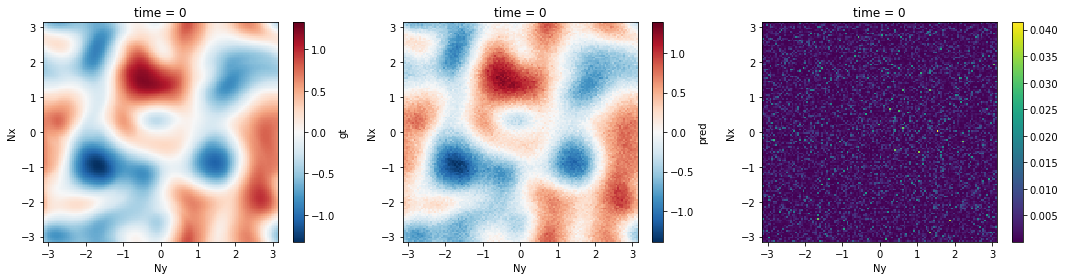

In [6]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 4))

ds_eval.gt.isel(time=0).plot(ax=ax[0])
ds_eval.pred.isel(time=0).plot(ax=ax[1])
np.square(ds_eval.pred - ds_eval.gt).isel(time=0).plot(ax=ax[2])
plt.tight_layout()
plt.show()

## Format Dataset

In [7]:
check_coords(ds_eval, ["Nx", "Ny", "time"])

True

## Compute Scores

### RMSE-Based Score

In [8]:
# temporal rmse
nrmse_t = rmse_coords(ds_eval["pred"], ds_eval["gt"], ["Nx", "Ny"], normalized=True)

# temporal stability of the error
recon_err_stability_metric_t = nrmse_t.std().values

# spatial rmse
nrmse_xy = rmse_coords(ds_eval["pred"], ds_eval["gt"], ["time"], normalized=True)

# spatial stability of the error
recon_err_stability_metric_xy = nrmse_xy.std().values

# leaderboard rmse
nrmse_leaderboard = rmse_coords(ds_eval["pred"], ds_eval["gt"], None, normalized=True)


print(f"Leaderboard RMSE score = {np.round(nrmse_leaderboard.values, 2)}")
print(f"Error Variability (Temporal) = {np.round(recon_err_stability_metric_t, 2)}")
print(f"Error Variability (Spatial) = {np.round(recon_err_stability_metric_xy, 2)}")

Leaderboard RMSE score = 0.93
Error Variability (Temporal) = 0.01
Error Variability (Spatial) = 0.04


### Spectral Scores

In [9]:
dt = 1

time_coords = ds_eval.time.values.astype(np.float64)

time_coords = reformat_time(
    time_coords, dt
)
time_coords = time_coords.astype(np.float64)
ds_eval["time"] = time_coords

In [12]:
psd_coords = ["Ny", "time", "Nx"]

ds_psd = compute_psd(ds_eval["gt"], ds_eval["pred"], psd_coords)

[                                        ] | 0% Completed |  0.0s

/home/johnsonj/miniconda3/envs/oi_torch_py39/lib/python3.9/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


[########################################] | 100% Completed |  0.7s
[#####                                   ] | 14% Completed |  0.1s

/home/johnsonj/miniconda3/envs/oi_torch_py39/lib/python3.9/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


[########################################] | 100% Completed |  0.7s


In [13]:
ds_psd

<xarray.Dataset>
Dimensions:     (freq_time: 62, freq_Nx: 63)
Coordinates:
  * freq_time   (freq_time) float64 0.008 0.016 0.024 0.032 ... 0.48 0.488 0.496
  * freq_Nx     (freq_Nx) float64 0.1592 0.3183 0.4775 ... 9.708 9.868 10.03
Data variables:
    psd_diff    (freq_time, freq_Nx) float64 1.672e-05 1.821e-05 ... 1.772e-05
    psd_signal  (freq_time, freq_Nx) float64 2.754 0.2837 ... 2.509e-11
    psd_score   (freq_time, freq_Nx) float64 1.0 0.9999 ... -7.065e+05

In [14]:
resolved_scales = shortest_resolved_scale(ds_psd)

In [15]:

print(f"Leaderboard:")

for iname, ivalue in resolved_scales.items():
    
    print(f"Spectral Score (Coord: '{iname}') = {ivalue:.3f}")


Leaderboard:
Spectral Score (Coord: 'freq_time') = 8.502
Spectral Score (Coord: 'freq_Nx') = 0.530


## Export Scores

In [21]:
tab_score = pd.DataFrame(
    dict(name=["baseline"],
         mu_RMSE=[np.round(nrmse_leaderboard.values, 3)],
         std_RMSE=[np.round(recon_err_stability_metric_t, 3)],
         lambda_x_degree=[resolved_scales["freq_Nx"]],
         lambda_t_days=[resolved_scales["freq_time"]],
         Notes = ['baseline'])
)
tab_score

,name,mu_RMSE,std_RMSE,lambda_x_degree,lambda_t_days,Notes
0,baseline,0.931,0.01,0.530252,8.502384,baseline


## Visualization

### Spectral Scores

### nRMSE Temporal

### Spatial Maps